Przygotowanie danych:

In [12]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import meteostat
from datetime import datetime

HTML = open('coordinates.html', "r")

with open('coordinates.html', "r") as HTML:
    soup = BeautifulSoup(HTML, 'html.parser')
    tab = soup.find('table', {'class': 'table-sort tablss'})
    rows = tab.find_all('tr')

    tab_data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [col.get_text(strip=True) for col in cols]
        tab_data.append(cols)

locations = pd.DataFrame(tab_data)
locations.dropna(inplace=True)
locations.columns = ["capital", "country", "latitude", "longitude"]
berlin = locations[locations['capital'] == 'Berlin']


def degrees_to_decimal(degrees, direction):
    pre, end = degrees.split('.')
    end = float(end) * (5 / 3)
    decimal_degrees = float(pre) + end * 0.01
    if direction in ['S', 'W']:
        decimal_degrees *= -1
    return decimal_degrees


locations['longitude'] = locations['longitude'].str.extract(r'(\d+\.\d+)([NSWE])').apply(
    lambda x: degrees_to_decimal(*x), axis=1)
locations['latitude'] = locations['latitude'].str.extract(r'(\d+\.\d+)([NSWE])').apply(lambda x: degrees_to_decimal(*x),
                                                                                       axis=1)

Wyznaczenie średnich wartości dla stolic: 

In [3]:
start = datetime(2022, 1, 1)
end = datetime(2022, 12, 30)
arr_tavg = []
arr_tmax = []
arr_prcp = []
for country in locations['country'].unique():
    co = locations[locations['country'] == country]
    stations = meteostat.Stations()
    stations = stations.nearby(float(co['latitude'].iloc[0]), float(co['longitude'].iloc[0]))
    station = stations.fetch(1)
    data = meteostat.Daily(station, start, end)
    data = data.fetch()
    tavg = data.mean()['tavg']
    tmax = data.max()['tmax']
    prcp = data.mean()['prcp']
    arr_tavg.append(tavg)
    arr_tmax.append(tmax)
    arr_prcp.append(prcp)

locations.insert(4, "average temperature", arr_tavg, True)
locations.insert(5, "average precipitation", arr_prcp, True)
locations.insert(6, "max temperature", arr_tmax, True)


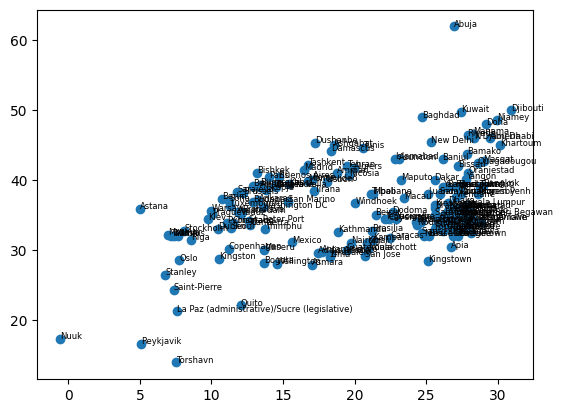

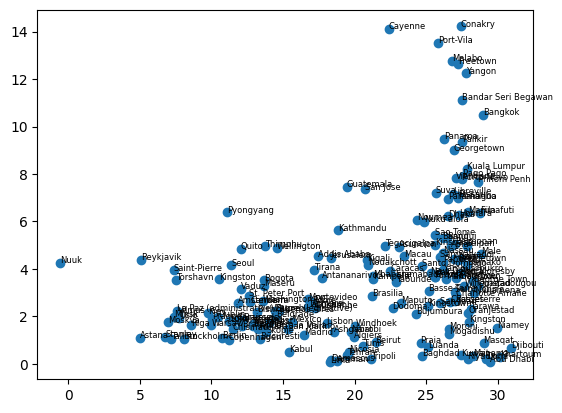

In [32]:
import matplotlib.pyplot as plt

locations = locations.dropna(axis=0, how='any')

plt.scatter(locations['average temperature'], locations['max temperature'])
for index, row in locations.iterrows():
    plt.text(row['average temperature'], row['max temperature'], row['capital'], fontsize=6)
plt.show()

plt.scatter(locations['average temperature'], locations['average precipitation'])
for index, row in locations.iterrows():
    plt.text(row['average temperature'], row['average precipitation'], row['capital'], fontsize=6)
plt.show()



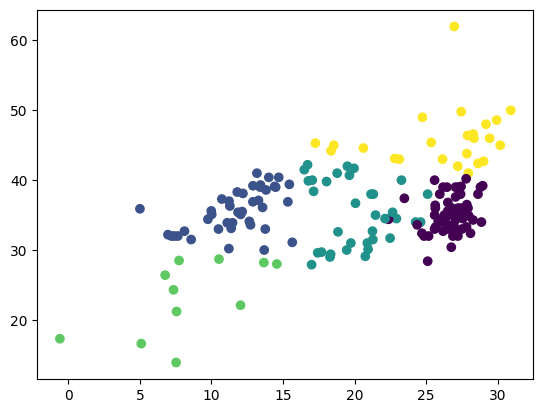

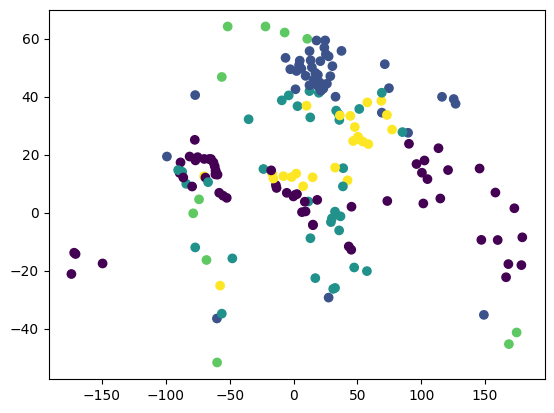

In [52]:
from sklearn.cluster import KMeans

X = locations[['average temperature', 'average precipitation', 'max temperature']]

kmeans = KMeans(n_clusters=5).fit(X)
locations = locations.drop(columns=['group'])
locations.insert(7, "group", kmeans.labels_)

plt.scatter(locations['average temperature'], locations['max temperature'], c=kmeans.labels_)
plt.show()

plt.scatter(locations['longitude'], locations['latitude'], c=kmeans.labels_, cmap='viridis')
plt.show()